# Text Mining 'Friends' 
#### (inspired by [Text Mining South Park](http://kaylinwalker.com/text-mining-south-park/))

In [1]:
import os
from IPython.display import Image
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import nltk

%matplotlib inline

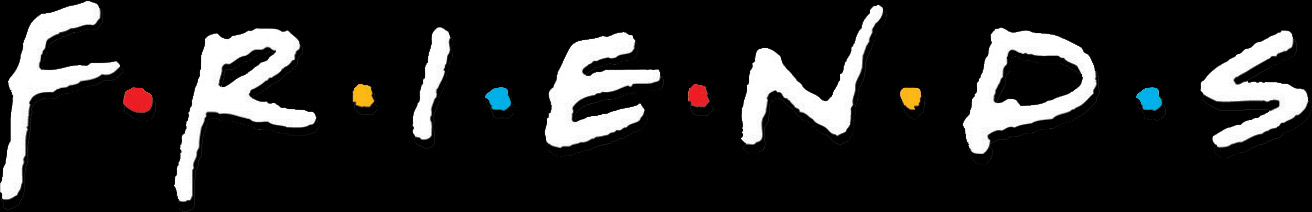

In [2]:
Image('friends_logo_b.jpg')

Parse transcripts in one big text file

In [3]:
friends  = {'joey', 'phoebe', 'monica', 'rachel', 'chandler', 'ross'}
friends_short = {'joey':'joey', 'phoe':'phoebe', 'mnca':'monica', 'rach':'rachel', 'chan':'chandler', 'ross':'ross'}

In [4]:
tcsdir = 'transcripts'
speakers = {}
words_count = {}
raw_transcript = []
episode_len = {}
episode = 0
episodes = 0
scenes = []
for f in os.listdir(tcsdir):
    raw_html = open(tcsdir + '/' + f, 'r').readlines()
    for line in raw_html:
        if ('<b>' in line or '<p>' in line or '<br>' in line) and ':' in line and 'Written by' not in line:
            text = re.sub('<[^<]+?>', '', line)
            raw_transcript.append(text)
            try:
                speaker = text[0:text.index(':')].lower()
                if speaker == '[scene':
                    scene = text[text.index(':')+2:-1]
                    scene = scene.replace(']', '')
                    scene = scene.replace('\r', '')
                    scene = scene.replace('&#146;', '\'')
                    scenes.append(scene.lower())
                else:
                    text = text[text.index(':'):]
                    if speaker in friends_short:
                        speaker = friends_short[speaker]
                    if speaker in speakers.keys():
                        speakers[speaker] += 1
                        words_count[speaker] += len(re.findall(r'\w+', text))
                    else:
                        speakers[speaker] = 1
                        words_count[speaker] = len(re.findall(r'\w+', text))
            except ValueError:
                pass
    
    if episodes == 0:
        episode_len[f] = (0, len(raw_transcript))
    else:
        prev_ep_end = episode_len[episode][0]+episode_len[episode][1]
        episode_len[f] = (prev_ep_end, len(raw_transcript)-prev_ep_end)
    episode = f
    episodes += 1
                          
print 'Episodes count: {}'.format(episodes)

Episodes count: 229


In [5]:
print ''.join(raw_transcript[-5:])

Chandler: Oh, it's gonna be okay.
Rachel: (crying) Do you guys have to go to the new house right away, 
Monica: We got some time.
Rachel: Okay, should we get some coffee?
Chandler: Sure. Where?



In [6]:
zi_speakers = sorted(speakers.items(), key=lambda x: x[1])
zi_speakers[-20:]

[('gunther', 128),
 ('paul', 133),
 ('david', 137),
 ('frank', 142),
 ('tag', 146),
 ('mrs. geller', 174),
 ('charlie', 188),
 ('carol', 190),
 ('emily', 202),
 ('mr. geller', 208),
 ('janice', 215),
 ('richard', 230),
 ('all', 336),
 ('mike', 353),
 ('phoebe', 7304),
 ('joey', 8034),
 ('monica', 8231),
 ('chandler', 8281),
 ('ross', 8910),
 ('rachel', 9088)]

In [7]:
print 'All speakers: {}'.format(len(speakers.keys()))

All speakers: 1051


### Can you remember them all? Let's see a wordcloud sized by person's word amount.  
For that purpose I use awesome package [git://github.com/amueller/word_cloud.git](git://github.com/amueller/word_cloud.git)

In [8]:
zi_words_count = sorted(words_count.items(), key=lambda x: x[1])
print zi_words_count[-27:]

[('woman', 792), ('gary', 797), ('joshua', 894), ('mona', 933), ('gunther', 1002), ('pete', 1028), ('erica', 1030), ('amy', 1053), ('all', 1073), ('paul', 1090), ('tag', 1177), ('frank', 1273), ('carol', 1411), ('david', 1473), ('mrs. geller', 1553), ('richard', 1675), ('charlie', 1753), ('emily', 1864), ('mr. geller', 1930), ('janice', 2050), ('mike', 3168), ('phoebe', 67572), ('monica', 72993), ('chandler', 75798), ('joey', 76377), ('rachel', 81271), ('ross', 82031)]


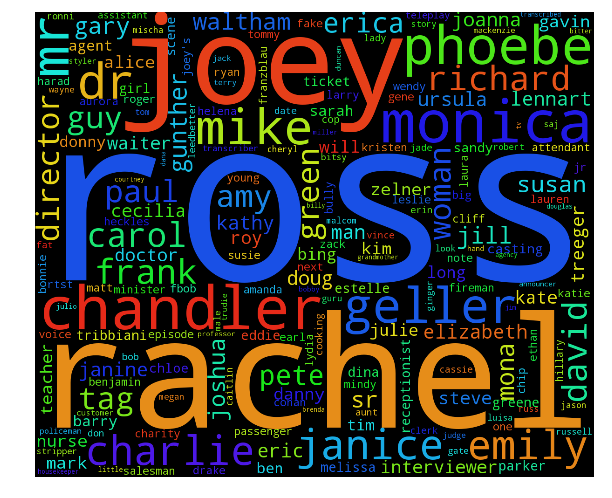

In [9]:
from wordcloud import WordCloud

wc_text = ''
for person, wc in zi_words_count:
    wc_text += (' '+person)*wc

fig = plt.figure(figsize=(10, 12))
wordcloud = WordCloud(background_color='black',
                          width=1200,
                          height=1000).generate(wc_text)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [10]:
all_other = sum(zip(*zi_words_count[:-27])[1])
allws = sum(zip(*zi_words_count)[1])
all_without_frs = sum(zip(*zi_words_count[:-6])[1])

print 'All other words: {}; all words count: {}; all without friends: {}'.format(all_other, allws, all_without_frs)

All other words: 61788; all words count: 546849; all without friends: 90807


In [11]:
uws = ''.join(raw_transcript).lower()
uws = re.findall(r'\w+', uws)
porter = nltk.PorterStemmer()
unique_words = set([porter.stem(t) for t in uws])

print 'Unique words: {}'.format(len(unique_words))

Unique words: 9949


In [12]:
freqs = [(round(float(words_count[friend])/allws, 3), friend) for friend in friends]
freqs.append((round(float(all_without_frs)/allws, 3), 'other'))
freqs.sort()
freqs

[(0.124, 'phoebe'),
 (0.133, 'monica'),
 (0.139, 'chandler'),
 (0.14, 'joey'),
 (0.149, 'rachel'),
 (0.15, 'ross'),
 (0.166, 'other')]

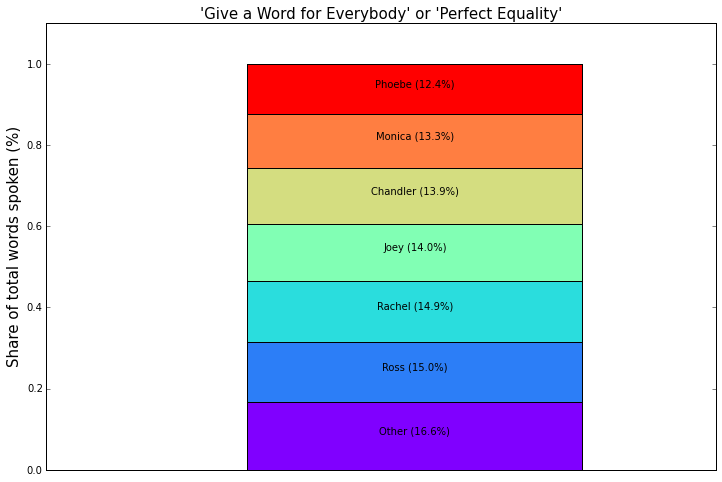

In [13]:
width = 0.25
plt.figure(figsize=(12, 8))

prev = 0
colors = cm.rainbow(np.linspace(0, 1, len(freqs)))
for freq, clr in zip(freqs[-1::-1], colors):
    br = [freq[0]]
    label=freq[1].title() + ' (' + str(freq[0]*100) + '%)'
    rect = plt.bar(0, br, width, bottom=[prev], color=clr).patches[0]
    prev += freq[0]

    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_y() + rect.get_height()/2, label, ha='center', va='bottom')


plt.ylabel('Share of total words spoken (%)', fontsize=15)
plt.title('\'Give a Word for Everybody\' or \'Perfect Equality\'', fontsize=15)
plt.xticks([])
plt.xlim(-0.15, 0.35)
plt.ylim(0, 1.1)

plt.show()

In [14]:
epnumbers = []
friends_throw_eps  = {fr:[] for fr in friends}

for ep in episode_len.keys():
    epn = None
    try:
        epn = float(ep[:ep.index('.html')])
    except Exception:
        print ep

1017-1018.html
0615-0616.html
07outtakes.html
0212-0213.html
0923-0924.html
0423uncut.html
0523-0524.html


In [15]:
for ep in episode_len.keys():
    epn = None
    try:
        if '-' in ep:
            epn = float(ep[:ep.index('-')])
        else:
            epn = float(ep[:ep.index('.html')])
    except Exception:
        continue
    epnumbers.append(epn)
    st, end = episode_len[ep]
    ep_trscs = raw_transcript[st : st+end]
    for fr in friends:
        friends_throw_eps[fr].append(0)
    for line in ep_trscs:
        if ':' in line:
            speaker = line[0:line.index(':')].lower()
            if speaker in friends_short:
                        speaker = friends_short[speaker]
            text = line[line.index(':'):].lower()
            if speaker in friends:
                friends_throw_eps[speaker][-1] += len(re.findall(r'\w+', text))

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


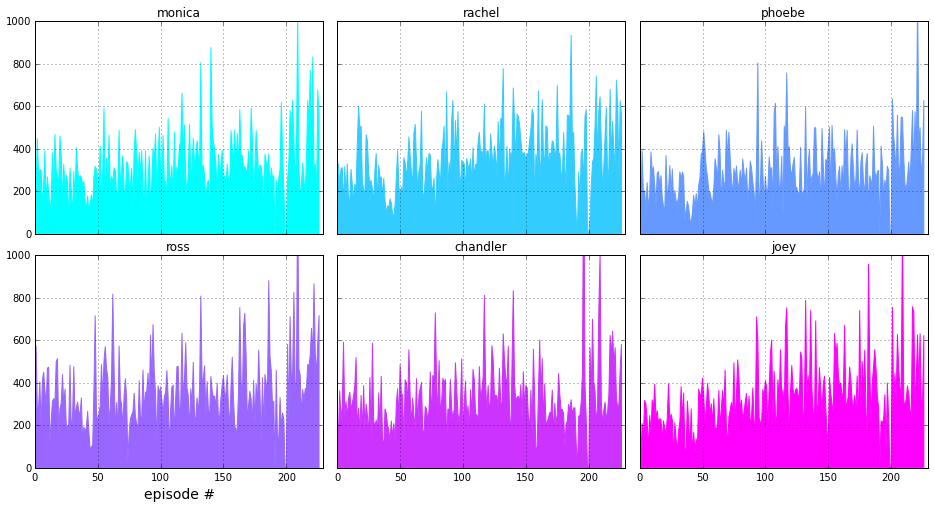

In [16]:
fig, axes = plt.subplots(figsize = (16, 8), ncols=3, nrows=2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.1)

ind  = 0
colors = cm.cool(np.linspace(0, 1, len(friends)))
for fr in friends:
    ps = zip(epnumbers, friends_throw_eps[fr])
    ps.sort()
    ps1, ps2 = zip(*ps)
    ax = axes[0 if ind < 3 else 1][ind%3]
    ax.fill_between(np.arange(0, len(epnumbers), 1), [0]*len(ps2), ps2, color=colors[ind])
    ax.set_title(fr)
    ind += 1
    ax.grid()
ax.set_xlim(0, 229)
ax.set_ylim(0, 1000)
axes[1][0].set_xlabel('episode #', fontsize=14)

plt.show()

In [17]:
friends_wc  = {fr:{} for fr in friends}
friends_wc['other'] = {}
wc = {}

In [18]:
for line in raw_transcript:
    if ':' in line:
        speaker = line[0:line.index(':')].lower()
        if speaker in friends_short:
            speaker = friends_short[speaker]
        if speaker not in friends:
            speaker = 'other'
        text = line[line.index(':'):].lower()
        ws = [porter.stem(t) for t in re.findall(r'\w+', text)]
        for word in ws:
            if word in friends_wc[speaker]:
                friends_wc[speaker][word] += 1
            else:
                friends_wc[speaker][word] = 1
            if word in wc:
                wc[word] += 1
            else:
                wc[word] = 1

In [19]:
total = sum([wc[w] for w in wc.keys()])
total

578425

In [20]:
wsdata = []
for fr in friends:
    fr_sum = sum([friends_wc[fr][w] for w in friends_wc[fr].keys()])
    for w in friends_wc[fr].keys():
        fq = friends_wc[fr][w]
        wsdata.append((fr, w,
                       (fq, wc[w]-fq, wc[w], fr_sum-fq, total-fr_sum+fq-wc[w], total-wc[w], fr_sum, total-fr_sum, total)))

len(wsdata)

22193

In [21]:
def ll(p):
    name = p[0]
    word = p[1]
    wd = p[2]
    E1 = float(wd[6]) * wd[2] / wd[8]
    E2 = float(wd[7]) * wd[2] / wd[8]
    log_likelihood = 2 * ( wd[0] * np.log(float(wd[0])/E1) + wd[1] * np.log(float(wd[1]/E2)))
    
    if(abs(log_likelihood) > 10.83):
        if E1 > wd[0]:
            log_likelihood = -log_likelihood
    
    return log_likelihood

In [22]:
ll_list = []
for p in wsdata:
    ll_list.append((p[0], p[1], ll(p)))

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


In [23]:
ll_frs = {fr:[] for fr in friends}
for p in ll_list:
    if not np.isnan(p[2]):
        ll_frs[p[0]].append((p[2]*len(p[1]), p[1]))

In [24]:
for w in ll_frs['joey']:
    if w[1] == 'doin':
        print w

(243.21528191500266, u'doin')


In [25]:
for fr in friends:
    ll_frs[fr].sort()
    print fr.title()
    print ll_frs[fr][:10]
    print ll_frs[fr][-10:]    

Monica
[(-2118.4028188142847, u'monica'), (-820.15540290212323, u'central'), (-409.24382828365947, u'yeah'), (-288.23129600483139, u'and'), (-288.1726589492888, u'ross'), (-221.65526068111467, u'apart'), (-221.4272765928676, u'rachel'), (-176.73591328038754, u'uh'), (-167.85804103416172, u'joey'), (-130.80596331096081, u'whoa')]
[(114.6101077002678, u'borrow'), (116.10351518585995, u'meddl'), (117.59208153654122, u'minut'), (123.34169277423403, u'umm'), (124.69337712288979, u'turkey'), (147.4340703964518, u'michel'), (168.0010609083466, u'god'), (201.62335915201325, u'honey'), (270.19401995418968, u'you'), (307.41001984678275, u'sweeti')]
Rachel
[(-2565.2930429651683, u'rachel'), (-1430.9900339686542, u'chandler'), (-704.44287329696351, u'central'), (-437.15147801505248, u'perk'), (-388.18209161537806, u'rach'), (-341.9417713385933, u'the'), (-287.0324078892591, u'monica'), (-258.49908185617119, u'and'), (-240.58963801029785, u'hey'), (-233.36717141054692, u'everyon')]
[(280.6641211608

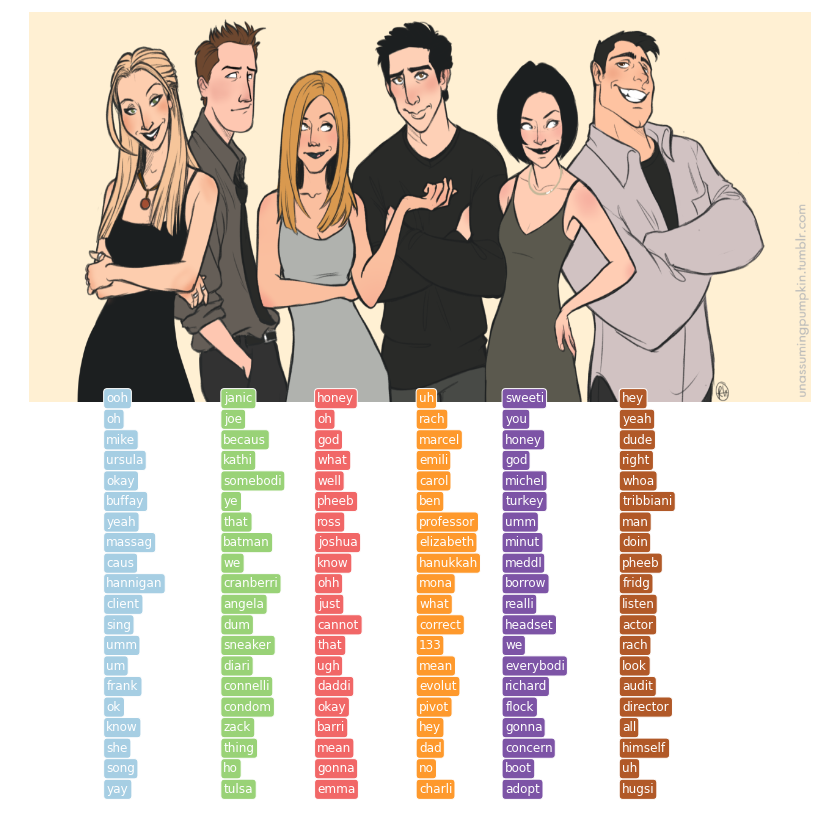

In [26]:
fig, axes = plt.subplots(figsize = (14,14), nrows=2)
fig.subplots_adjust(wspace=0., hspace=0.)
friends_final  = ['phoebe', 'chandler', 'rachel', 'ross', 'monica', 'joey']
x_coords = [0.1, 0.25, 0.37, 0.5, 0.61, 0.76]

im = plt.imread('friends_all.png')
implot = axes[0].imshow(im, aspect='auto')
implot.axes.set_axis_off()

ax = axes[1]
# colors = cm.rainbow(np.linspace(0, 1, len(friends)*2 + 2))
colors = cm.Paired(np.linspace(0, 1, len(friends)))
ind = 2
N = 20

for ind in range(0, 6, 1):
    friend = friends_final[ind]
    xcoord = x_coords[ind]
#     ycoords = np.linspace(0, 0.5, N)
    ycoords = np.linspace(0, 1., N)
    ll_frs_fr = ll_frs[friend]
    ll_frs_fr.sort()
#     for i in range(0, N, 1):
#         word = ll_frs_fr[i][1]
#         ycoord = ycoords[i]
#         ax.text(xcoord, ycoord, word, color='white', fontsize=12,
#             bbox=dict(facecolor=colors[ind], edgecolor='white', boxstyle='round'))
#     ycoords = np.linspace(0.56, 1.06, N)
    for i in range(-N, 0, 1):
        word = ll_frs_fr[i][1]
        ycoord = ycoords[i]
        ax.text(xcoord, ycoord, word, color='white', fontsize=12,
            bbox=dict(facecolor=colors[ind], edgecolor='white', boxstyle='round'))
        
    ind += 1

ax.axes.set_axis_off()
plt.show()

# Scenes

In [27]:
print 'Total number of scenes: {}\n'.format(len(scenes))
text = ' '.join(scenes)

print '-in Central Perk: {}' .format(text.count('central perk'))
print '---include on the couch: {}\n' .format(text.count('on the couch'))

print '-in offices: {}' .format(text.count('office'))
print '--in Chandler office: {}' .format(text.count('chandler\'s office'))
print '--in Raichel office: {}\n' .format(text.count('rachel\'s office'))

print '-in apartments: {}' .format(text.count('apartment'))
for fr in friends:
    count = text.count(fr + '\'s apartment')
    if count > 0:
        print '--in {} apartments: {}' .format(fr.title(), count)
print '--in Chandler and Joey\'s apartments: {}' .format(text.count('chandler and joey\'s apartment') + 
                                                        text.count('joey and chandler\'s apartment'))
print '--in Monica and Rachel\'s apartment: {}' .format(text.count('monica and rachel\'s apartment') +
                                                       text.count('rachel and monica\'s apartment'))
print '--in Monica and Chandler\'s apartment: {}' .format(text.count('monica and chandler\'s apartment') + 
                                                          text.count('chandler and monica\'s apartment'))
print '--in Ross and Rachel\'s apartment: {}' .format(text.count('ross and rachel\'s apartment'))
print '--in Joey and Rachel\'s apartment: {}\n' .format(text.count('joey and rachel\'s apartment'))

print '-on streets: {}' .format(text.count('street'))

Total number of scenes: 2648

-in Central Perk: 441
---include on the couch: 92

-in offices: 125
--in Chandler office: 31
--in Raichel office: 25

-in apartments: 334
--in Monica apartments: 14
--in Rachel apartments: 72
--in Phoebe apartments: 21
--in Ross apartments: 59
--in Chandler apartments: 24
--in Joey apartments: 49
--in Chandler and Joey's apartments: 20
--in Monica and Rachel's apartment: 45
--in Monica and Chandler's apartment: 27
--in Ross and Rachel's apartment: 15
--in Joey and Rachel's apartment: 11

-on streets: 43
